# MoonIndex - M3 detailed indexes

Spectral indexes for the Moon Mineralogical Mapper (M3). This notebook describes the individual indexes.

Author:Javier Eduardo Suarez Valencia

Contact: jsuarezvalencia@constructor.university

In [2]:
#Importing libraries
import rioxarray as riox
import numpy as np
import MoonIndex.preparation
import MoonIndex.plotting
import MoonIndex.filtration
import MoonIndex.indexes

# Importing data and preparation

The preparation functions are described in the M3_total_indexes notebook.

In [ ]:
#Defining the paths
path_data='/home/jovyan/work/Index/data' #Path to the data
path_results='/home/jovyan/work/Index/results'#Path to the results
target='M3_Apollo' #Name of the used cube

#Import data: raster and wavelengths
input_cube=riox.open_rasterio(f'{path_data}/{target}.tif') 
wavelengths_full=np.loadtxt(f'{path_data}/Wavelength.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it
wavelengths_full=(wavelengths_full).astype(np.float32)

#This function attach the wavelength to the cube, sets the no value data to 0 and deletes the two first malfunctioning bands, and the bands after 2700 nm
M3_input_cube=MoonIndex.preparation.attach_wavelen(input_cube,wavelengths_full)

#Cropping the cube
M3_cube=MoonIndex.preparation.crop_cube(M3_input_cube,-151,-31,-150,-30) #Inputs are the cube and the coordinates to crop, minx, miny, maxx, maxy
#Cropping the data with indexes
#M3_cube=MoonIndex.preparation.crop_cube_size(M3_input_cube,25,630,2700,2800)  #Inputs are the cubes and the coordinates of the cropping rectangle (x limits and y limits)

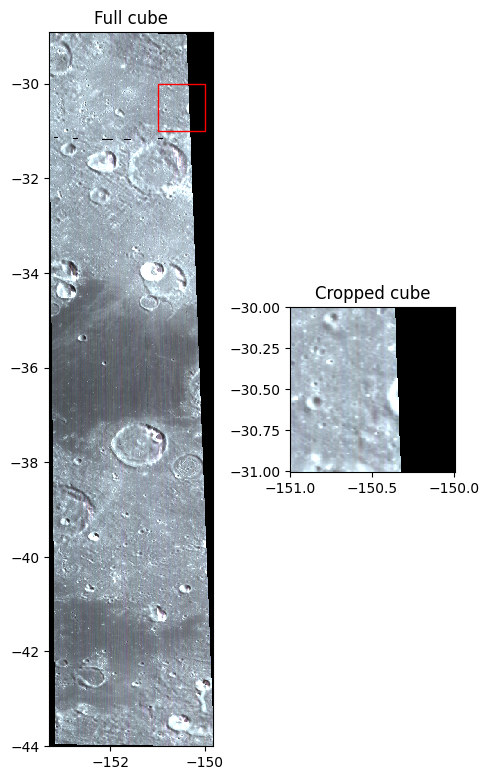

In [3]:
#PROVISIONAL IMPORT
#Import data: raster and wavelengths
input_cube=riox.open_rasterio('M3_Apollo.tiff') 
wavelengths_full=np.loadtxt('Wavelength.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it
wavelengths_full=(wavelengths_full).astype(np.float32)

#This function attach the wavelength to the cube, sets the no value data to 0 and deletes the two first malfunctioning bands, and the bands after 2700 nm
M3_input_cube=MoonIndex.preparation.attach_wavelen(input_cube,wavelengths_full)

#Cropping the cube
M3_cube=MoonIndex.preparation.crop_cube(M3_input_cube,-151,-31,-150,-30) #Inputs are the cube and the coordinates to crop, minx, miny, maxx, maxy
#Cropping the data with indexes
#M3_cube=MoonIndex.preparation.crop_cube_size(M3_input_cube,25,630,2700,2800)  #Inputs are the cubes and the coordinates of the cropping rectangle (x limits and y limits)

# Filtering and continuum removal

The filtering and continuum-removal functions are described in the M3_fitlering_removal notebook.

In [4]:
#Doing a fourier filtration, suggested size of the filter is 60x2
filter_width=60
filter_height=2
M3_fourier=MoonIndex.filtration.fourier_filter(M3_cube,filter_width,filter_height)  #Inputs the cube, and width and altitude of the mask in total percentage

#Doing a gaussian filtration
M3_gauss=MoonIndex.filtration.gauss_filter(M3_fourier,wavelengths_full)  #Inputs are the original cube and wavelengths

##CONVEX-HULL REMOVAL

#Function to find the midpoint to add to the convexhull
M3_midpoint=MoonIndex.preparation.midpoint(M3_gauss,wavelengths_full,6,0.002)

#Function to remove the continnum by the convex hull method, it is computed only until 2700 nm
M3_hull = MoonIndex.preparation.convexhull_removal(M3_gauss,wavelengths_full, M3_midpoint)  #Inputs are the filtered cube, wavelengths and the midpoint

# Making rasters with the wavelength of minimum reflectance in 1000 um and 2000 um respectively
M3_min1000, M3_min2000=MoonIndex.preparation.find_minimums_ch(M3_hull,M3_midpoint,wavelengths_full)  #Inputs are the convex hull and wavelengths, outputa the two minimums

#Obtaining the shoulders, point of maximum reflectance beetween the minimum
M3_shoulder0, M3_shoulder1, M3_shoulder2, M3_shoulder3=MoonIndex.preparation.find_shoulders_ch(M3_hull,M3_midpoint,M3_min1000,M3_min2000,wavelengths_full)  #Inputs convex hull and wavelengths, outputs the four shoulders

#LINEAR-FIT REMOVAL

#Continuum removal with the linear fit method
M3_lf=MoonIndex.preparation.continuum_removal_lf(M3_gauss,wavelengths_full,2,1) #Inptus are the filtered cube, wavelegnths, and the order of the polynomial fit for the 1000 nm and 2000 nm band

#Minimuums calculation with the linear fit method
M3_min1000lf,M3_min2000lf=MoonIndex.preparation.find_minimuumslf(M3_lf,wavelengths_full)

#Maximums calculation with the linear fit method
M3_shoulder0lf,M3_shoulder1lf,M3_shoulder2lf=MoonIndex.preparation.find_shoulders_lf(M3_lf,M3_min1000lf,M3_min2000lf,wavelengths_full)

# Indexes - General

These are single band indexes found in the literature, they operate over some bands to highlight the presence of certain minerals. These indexes are calculated before the continuum-removal, so they can be done right after the filtering. Since these are single-band parameters, use the image_plot function to visualize them. We plot only one as an example, the user can plot another ones.

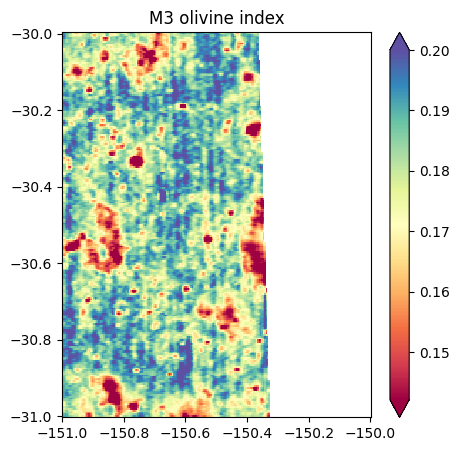

In [8]:
#R540, reflectance at 540 nm (Zambon et al., 2020)
M3_R540=MoonIndex.indexes.R540(M3_gauss) #Input filtered cube
#M3_R540.rio.to_raster(f'{path_results}/{target}_R540.tif') #Uncomment to export this index

#R1580, reflectance at 540 nm (Zambon et al., 2020)
M3_R1580=MoonIndex.indexes.R1580(M3_gauss) #Input filtered cube
#M3_R1580.rio.to_raster(f'{path_results}/{target}_R1580.tif')#Uncomment to export this index

#Spinel detection index (Moriarty III et al. 2022)
M3_sp=MoonIndex.indexes.spinel(M3_gauss)  #Input filtered cube
#M3_sp.rio.to_raster(f'{path_results}/{target}_Sp.tif')#Uncomment to export this index

#Olivine detection index  (Corley et al., 2018)
M3_ol=MoonIndex.indexes.olivine(M3_gauss)  #Input filtered cube
#M3_ol.rio.to_raster(f'{path_results}/{target}_Ol.tif')#Uncomment to export this index

#Chromite detection index (Moriarty III et al. 2022)
M3_cr=MoonIndex.indexes.chromite(M3_gauss)  #Input filtered cube
#M3_cr.rio.to_raster(f'{path_results}/{target}_cr.tif')#Uncomment to export this index

#FeO detection index  (Corley et al., 2018)
M3_fe=MoonIndex.indexes.iron(M3_gauss)  #Input filtered cube
#M3_fe.rio.to_raster(f'{path_results}/{target}_fe.tif')#Uncomment to export this index

#Ti detection index  (Corley et al., 2018)
M3_ti=MoonIndex.indexes.titanium(M3_gauss)  #Input filtered cube
#M3_ti.rio.to_raster(f'{path_results}/{target}_ti.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.image_plot(M3_ol,5,'M3 olivine index')

These are RGB composites found in the literaturethat highlight differences between mineral species. Since these are multiband indexes, use the cube_plot function. We plot the Spanpx index as an example.

In [7]:
#Clementine-like RGB. R: R750 nm/R540 nm, G:,R750 nm/R1000 nm, B:R540nm/R750 nm
M3_clem=MoonIndex.indexes.clementine(M3_gauss) #Inputs filtered cube
#M3_clem.rio.to_raster(f'{path_results}/{target}_CLEM.tif') #Uncomment to export this index

#RGB for mineral ratios. R: Pyroxene ratio, G: Spinel ratio, B:Anorthosite ratio (Pieters et al. 2014)
M3_spanpx=MoonIndex.indexes.RGB_spanpx(M3_gauss) #Inputs filtered cube
#M3_spanpx.rio.to_raster(f'{path_results}/{target}_Spanpx.tif') #Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_spanpx,5,'M3 Sp-An-Px')

# Indexes - Convex hull

These indexes were colected in the literature, mainly from Zambon et al. (2020), but also from Bretzfelder et al. (2020), Corley et al. (2018), and Horgan et al. (2014). Some indexes are used by other ones, so in the notebook they are calculated in order. The indexes plotted are examples.

In [9]:
#BCI, Band minimum at 1000
M3_BCI_CH=MoonIndex.indexes.band_center(M3_min1000)
#M3_BCI_CH.rio.to_raster(f'{path_results}/{target}_BCI_CH.tif')#Uncomment to export this index

#BCII, Band minimum at 2000
M3_BCII_CH=MoonIndex.indexes.band_center(M3_min2000)
#M3_BCII_CH.rio.to_raster(f'{path_results}/{target}_BCII_CH.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.image_plot(M3_BCII_CH,5,'M3 min 2000')

The band depth is obtained by dividing the reflectance by the value of the continuum at that location, always positive. The spectral slope of 1000 nm is calculated between the 540 nm band and the first shoulder (Zambon et al., 2020). (Zambon et al., 2020). 

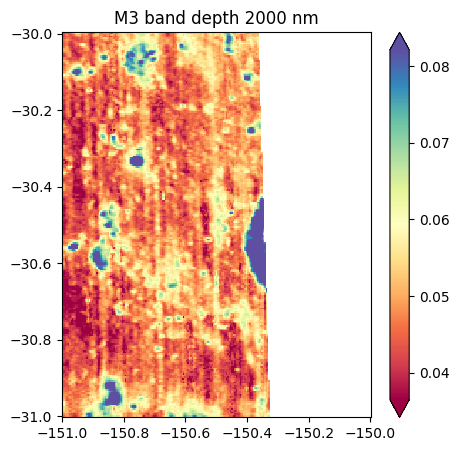

In [10]:
#BDI, band depth at 1000 nm with the convex hull method
M3_BDI_CH=MoonIndex.indexes.band_depth(M3_hull,M3_min1000,wavelengths_full)
#M3_BDI_CH.rio.to_raster(f'{path_results}/{target}_BDI_CH.tif')#Uncomment to export this index

#BDII, band depth at 2000 nm with the convex hull method
M3_BDII_CH=MoonIndex.indexes.band_depth(M3_hull,M3_min2000,wavelengths_full)
#M3_BDII_CH.rio.to_raster(f'{path_results}/{target}_BDII_CH.tif')#Uncomment to export this index

#SS1000, Spectral slope between maximun right shoulder and 540nm
M3_SSI_CH=MoonIndex.indexes.SSI(M3_gauss,M3_shoulder1,wavelengths_full) #Inputs are filtered cube, hull and wavelengths
#M3_SSI_CH.rio.to_raster(f'{path_results}/{target}_SSI_CH.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.image_plot(M3_BDII_CH,5,'M3 band depth 2000 nm')

These RGBs are composed from the previous indexes (Zambonet al. 2020).

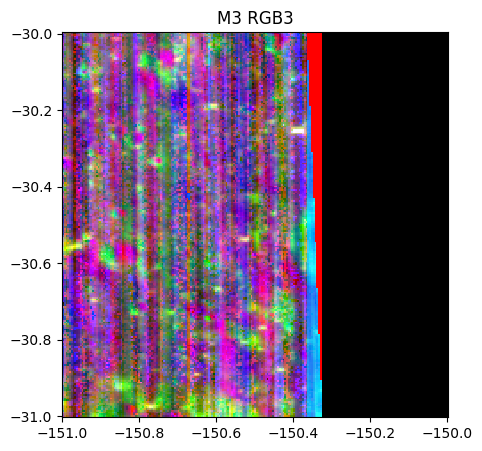

In [11]:
#RGB1. R: SSI, G: BDI, B: BDII. Better whitout gaussian
M3_RGB1_CH=MoonIndex.indexes.RGB1(M3_gauss,M3_SSI_CH,M3_BDI_CH,M3_BDII_CH) #Inputs filtered cube, SSI, BDI, BDII
#M3_RGB1_CH.rio.to_raster(f'{path_results}/{target}_RGB1_CH.tif')#Uncomment to export this index

#RGB2. R: SSI, G: R540 nm, B: BCII.
M3_RGB2_CH=MoonIndex.indexes.RGB2(M3_gauss, M3_SSI_CH, M3_R540,M3_BCII_CH)  #Inputs filtered cube, SSI, R540, BCII
#M3_RGB2_CH.rio.to_raster(f'{path_results}/{target}_RGB2_CH.tif')#Uncomment to export this index

#RGB3. R: SSBI, G: R540 nm, B: BCI.
M3_RGB3_CH=MoonIndex.indexes.RGB3(M3_gauss,M3_SSI_CH, M3_R540,M3_BCI_CH) #Inputs filtered cube, SSI, R540, BCI
#M3_RGB3_CH.rio.to_raster(f'{path_results}/{target}_RGB3_CH.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_RGB3_CH,5,'M3 RGB3')

The indexes RGB4 and RGB5 use parameters focused on the shape of the spectrum, the band area and asymmetry. The first one is calcualted by aproximation using the method of adding rectangles areas, and the second one calculates the area at both sides of the band centers and then asign the diference as a percentage (Horgan et al., 2014).  

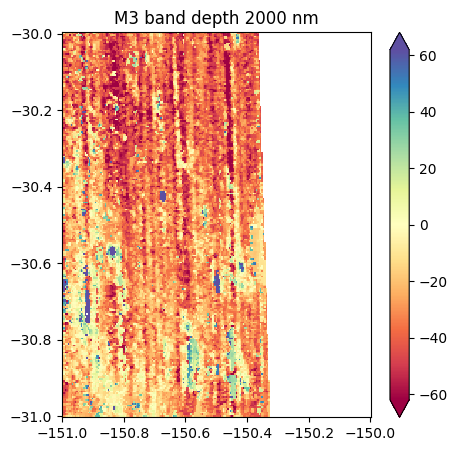

In [13]:
#Band area 1000 nm
M3_BAI_CH=MoonIndex.indexes.BA(M3_hull,wavelengths_full,M3_shoulder0,M3_shoulder1)

#Band area 2000 nm
M3_BAII_CH=MoonIndex.indexes.BA(M3_hull,wavelengths_full,M3_shoulder2,M3_shoulder3)

#Band asymmetry 1000 nm
M3_ASYI_CH=MoonIndex.indexes.ASY(M3_hull,wavelengths_full,M3_shoulder0,M3_shoulder1,M3_min1000)

#Band asymmetry 2000 nm
M3_ASYII_CH=MoonIndex.indexes.ASY(M3_hull,wavelengths_full,M3_shoulder2,M3_shoulder3,M3_min2000)

#Plot
MoonIndex.plotting.image_plot(M3_ASYII_CH,5,'M3 band depth 2000 nm')

In [14]:
#RGB4. R:BCI, G: BCII, B:BAI, this index combines the band centers wit the band area at 1000 nm
M3_RGB4_CH=MoonIndex.indexes.RGB4(M3_hull,wavelengths_full,M3_shoulder0,M3_shoulder1,M3_BCI_CH,M3_BCII_CH)  #Inputs are Filtered cube, wavelengths, shoudlers 0 and 1,min 1000 and 2000
#M3_RGB4_CH.rio.to_raster(f'{path_results}/{target}_RGB4_CH.tif')#Uncomment to export this index

#RGB5. R:ASY, G:BCI, B: BCII, this index combines the band asymmetry at 1000 with the center at 2000 and the band area at 1000
M3_RGB5_CH=MoonIndex.indexes.RGB5(M3_hull,wavelengths_full, M3_shoulder0,M3_shoulder1,M3_BCI_CH,M3_BCII_CH) #Inputs are filtered cube, wavelengths, shoudlers 0 and 1, minimmuns 1000 and 2000, and the band area 9calculated in a prior step)
#M3_RGB5_CH.rio.to_raster(f'{path_results}/{target}_RGB5_CH.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_RGB5_CH,5,'M3 RGB5')

These indexes were taken from Besse et al. 2011, usefull for the study of lunar maria.

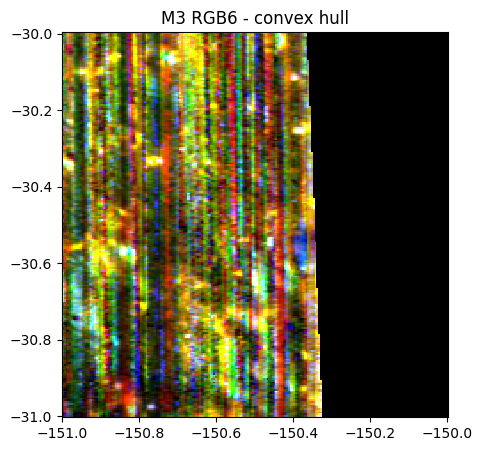

In [15]:
#IBDI, integrated band depth at 1000 nm
M3_IBDI_CH=MoonIndex.indexes.IBDI(M3_hull)
#M3_IBDI_CH.rio.to_raster(f'{path_results}/{target}_IBDI_CH.tif')#Uncomment to export this index

#IBDII, integrated band depth at 1000 nm
M3_IBDII_CH=MoonIndex.indexes.IBDII(M3_hull)
#M3_IBDII_CH.rio.to_raster(f'{path_results}/{target}_IBDII_CH.tif')#Uncomment to export this index

#RGB6, Band depths at 950, 1050 and 1250
M3_RGB6_CH=MoonIndex.indexes.RGB6(M3_hull)
#M3_RGB6_CH.rio.to_raster(f'{path_results}/{target}_RGB6_CH.tif')#Uncomment to export this index

#RGB7, BaNd depths at 950, 1050 and 1250
M3_RGB7_CH=MoonIndex.indexes.RGB7(M3_gauss,M3_R1580,M3_IBDI_CH,M3_IBDII_CH)
#M3_RGB7_CH.rio.to_raster(f'{path_results}/{target}_RGB7_CH.tif')#Uncomment to export this index

#Plotting
MoonIndex.plotting.cube_plot(M3_RGB6_CH,5,'M3 RGB6 - convex hull')

The RGB 8 index use the integrated band depths at 1000 nm and 2000 nm, those are similar to the band depth, but the operation is done at a defined range of wavelengths (Bretzfelder et al., 2020). The 2000 nm is calculated between 1658.71 nm and 2497.11 nm, and the 1000 nm is calculated between 790.37 nm and 1309.38 nm.

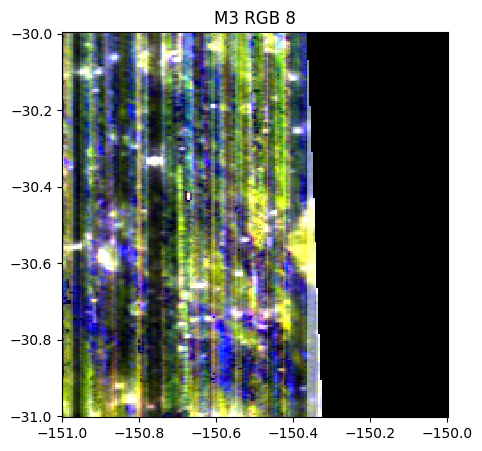

In [16]:
#NIR. R: band depth (BD) 1900, integrated band depth(IBD) 2000, integrated band depth (IBD) 1000
M3_RGB8_CH=MoonIndex.indexes.RGB8(M3_gauss,M3_hull)
#M3_RGB8_CH.rio.to_raster(f'{path_results}/{target}_RGB8_CH.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_RGB8_CH,5,'M3 RGB 8')

# Indexes - Linear fit

These are the same indexes, but calculated using the linear-fit continuum removal method.

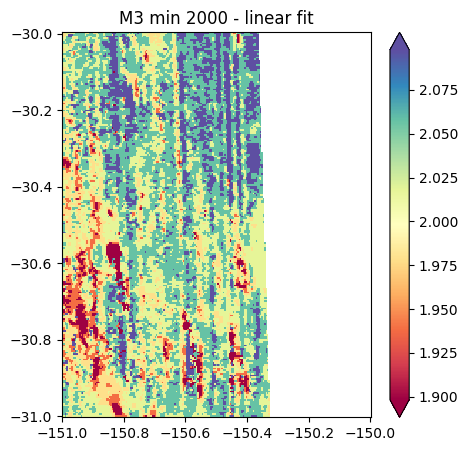

In [17]:
#BCI, Band minimum at 1000 linear-fit
M3_BCI_LF=MoonIndex.indexes.band_center(M3_min1000lf)
#M3_BCI_LF.rio.to_raster(f'{path_results}/{target}_BCI_LF.tif')#Uncomment to export this index

#BCII, Band minimum at 2000 linear-fit method
M3_BCII_LF=MoonIndex.indexes.band_center(M3_min2000lf)
#M3_BCII_LF.rio.to_raster(f'{path_results}/{target}_BCII_LF.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.image_plot(M3_BCII_LF,5,'M3 min 2000 - linear fit')

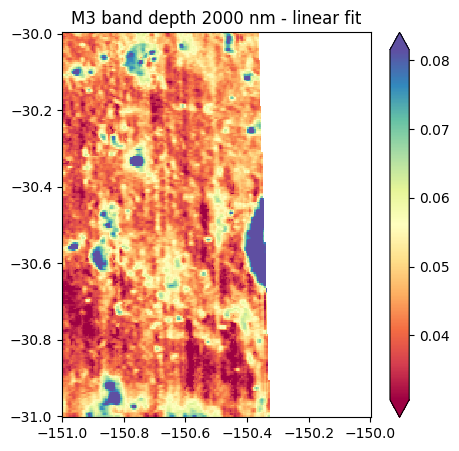

In [18]:
#BDI, band depth at 1000 nm with the linear fit method
M3_BDI_LF=MoonIndex.indexes.band_depth(M3_lf,M3_min1000lf,wavelengths_full)
#M3_BDI_LF.rio.to_raster(f'{path_results}/{target}_BDI_LF.tif')#Uncomment to export this index

#BDII, band depth at 1000 nm with the linear fit method
M3_BDII_LF=MoonIndex.indexes.band_depth(M3_lf,M3_min2000lf,wavelengths_full)
#M3_BDII_LF.rio.to_raster(f'{path_results}/{target}_BDII_LF.tif')#Uncomment to export this index

#SS1000, Spectral slope between maximun right shoulder and 540nm linear fit method
M3_SSI_LF=MoonIndex.indexes.SSI(M3_gauss,M3_shoulder1lf,wavelengths_full) #Inputs are filtered cube, hull and wavelengths
#M3_SSI_LF.rio.to_raster(f'{path_results}/{target}_SSI_LF.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.image_plot(M3_BDII_LF,5,'M3 band depth 2000 nm - linear fit')

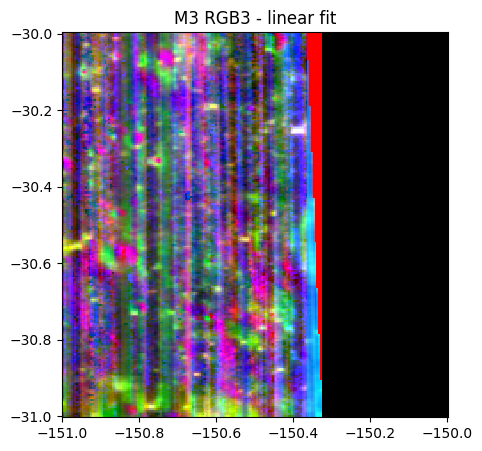

In [19]:
#RGBs (Zambon et al., 2020) with the linear fit method
#RGB1. R: SSI, G: BDI, B: BDII. Better whitout gaussian
M3_RGB1_LF=MoonIndex.indexes.RGB1(M3_gauss,M3_SSI_LF,M3_BDI_LF,M3_BDII_LF) #Inputs filtered cube, SSI, BDI, BDII
#M3_RGB1_LF.rio.to_raster(f'{path_results}/{target}_RGB1_LF.tif')#Uncomment to export this index

#RGB2. R: SSI, G: R540 nm, B: BCII.
M3_RGB2_LF=MoonIndex.indexes.RGB2(M3_gauss, M3_SSI_LF, M3_R540, M3_min2000lf)  #Inputs filtered cube, SSI, R540, BCII
#M3_RGB2_LF.rio.to_raster(f'{path_results}/{target}_RGB2_LF.tif')#Uncomment to export this index

#RGB3. R: SSBI, G: R540 nm, B: BCI.
M3_RGB3_LF=MoonIndex.indexes.RGB3(M3_gauss,M3_SSI_LF, M3_R540,M3_min1000lf) #Inputs filtered cube, SSI, R540, BCI
#M3_RGB3_LF.rio.to_raster(f'{path_results}/{target}_RGB3_LF.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_RGB3_LF,5,'M3 RGB3 - linear fit')

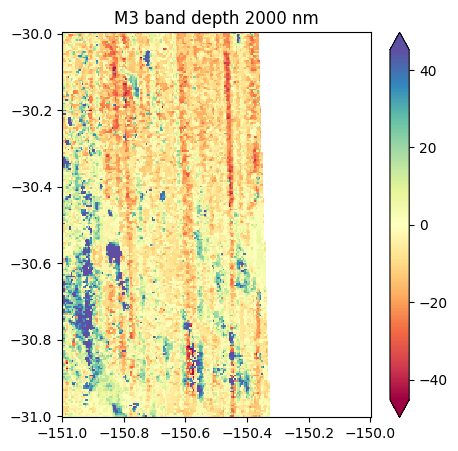

In [20]:
#Band area 1000 nm
M3_BAI_LF=MoonIndex.indexes.BA(M3_lf,wavelengths_full,M3_shoulder0lf,M3_shoulder1lf)

#Band area 2000 nm
M3_BAII_LF=MoonIndex.indexes.BA(M3_lf,wavelengths_full,M3_shoulder1lf,M3_shoulder2lf)

#Band asymmetry 1000 nm
M3_ASYI_LF=MoonIndex.indexes.ASY(M3_lf,wavelengths_full,M3_shoulder0lf,M3_shoulder1lf,M3_min1000lf)

#Band asymmetry 2000 nm
M3_ASYII_LF=MoonIndex.indexes.ASY(M3_lf,wavelengths_full,M3_shoulder1lf,M3_shoulder2lf,M3_min2000lf)

#Plot
MoonIndex.plotting.image_plot(M3_ASYII_LF,5,'M3 band depth 2000 nm')

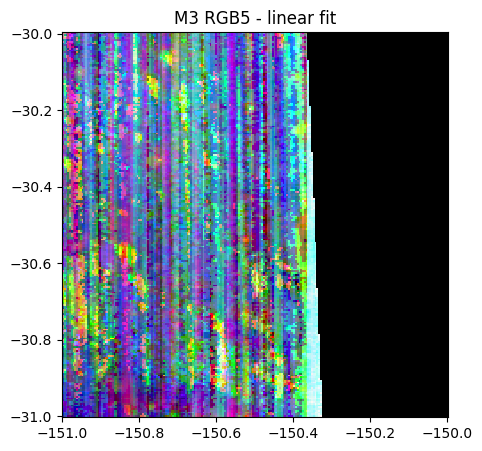

In [21]:
#RGBs Horgan with the linear fit method
#RGB4. R:BCI, G: BCII, B:BAI, this index combines the band centers wit the band area at 1000 nm
M3_RGB4_LF=MoonIndex.indexes.RGB4(M3_lf,wavelengths_full,M3_shoulder0lf,M3_shoulder1lf,M3_min1000lf,M3_min2000lf)  #Inputs are Filtered cube, wavelengths, shoudlers 0 and 1,min 1000 and 2000
#M3_RGB4_LF.rio.to_raster(f'{path_results}/{target}_RGB4_LF.tif')#Uncomment to export this index

#RGB5. R:ASY, G:BCI, B: BCII, this index combines the band asymmetry at 1000 with the center at 2000 and the band area at 1000
M3_RGB5_LF=MoonIndex.indexes.RGB5(M3_lf,wavelengths_full, M3_shoulder0lf,M3_shoulder1lf,M3_min1000lf,M3_min2000lf) #Inputs are filtered cube, wavelengths, shoudlers 0 and 1, minimmuns 1000 and 2000, and the band area 9calculated in a prior step)
#M3_RGB5_LF.rio.to_raster(f'{path_results}/{target}_RGB5_LF.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_RGB5_LF,5,'M3 RGB5 - linear fit')

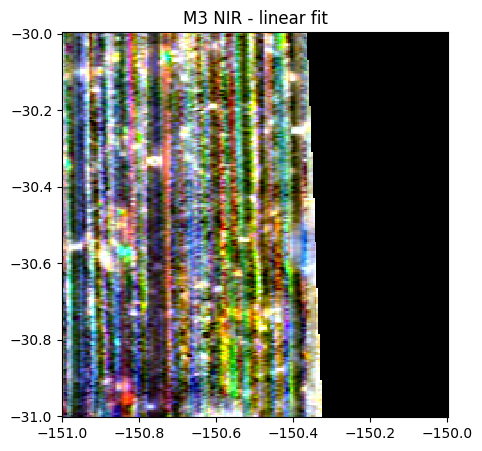

In [22]:
#IBDI, integrated band depth at 1000 nm
M3_IBDI_LF=MoonIndex.indexes.IBDI(M3_lf)
#M3_IBDI_LF.rio.to_raster(f'{path_results}/{target}_IBDI_LF.tif')#Uncomment to export this index

#IBDII, integrated band depth at 1000 nm
M3_IBDII_LF=MoonIndex.indexes.IBDII(M3_lf)
#M3_IBDII_LF.rio.to_raster(f'{path_results}/{target}_IBDII_LF.tif')#Uncomment to export this index

#RGB6, Band depths at 950, 1050 and 1250
M3_RGB6_LF=MoonIndex.indexes.RGB6(M3_lf)
#M3_RGB6_LF.rio.to_raster(f'{path_results}/{target}_RGB6_LF.tif')#Uncomment to export this index

#RGB7, Band depths at 950, 1050 and 1250
M3_RGB7_LF=MoonIndex.indexes.RGB7(M3_gauss,M3_R1580,M3_IBDI_LF,M3_IBDII_LF)
#M3_RGB7_LF.rio.to_raster(f'{path_results}/{target}_RGB7_LF.tif')#Uncomment to export this index
                                  
#Plot
MoonIndex.plotting.cube_plot(M3_RGB6_LF,5,'M3 NIR - linear fit')

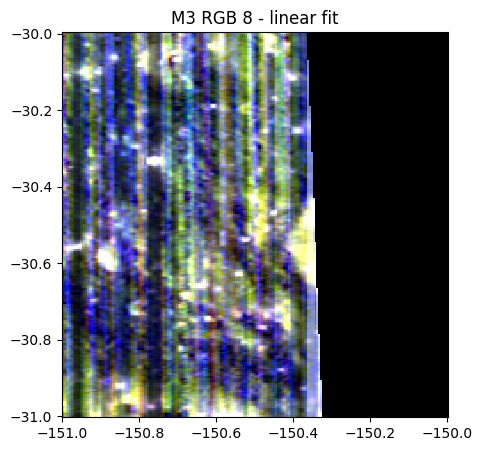

In [23]:
#RGB8. R: band depth (BD) 1900, integrated band depth(IBD) 2000, integrated band depth (IBD) 1000, lienar fit method
M3_RGB8_LF=MoonIndex.indexes.RGB8(M3_gauss,M3_lf)
#M3_RGB8_LF.rio.to_raster(f'{path_results}/{target}_RGB8_LF.tif')#Uncomment to export this index

#Plot
MoonIndex.plotting.cube_plot(M3_RGB8_LF,5,'M3 RGB 8 - linear fit')

# References

Bretzfelder, J. M., Klima, R. L., Greenhagen, B. T., Buczkowski, D. L., Petro, N. E., & Day, M. (2020). Identification of Potential Mantle Rocks Around the Lunar Imbrium Basin. Geophysical Research Letters, 47(22). https://doi.org/10.1029/2020GL090334

Clenet, H. (2009). Télédétection hyperspectrale: Minéralogie et pétrologie, Application au volcan Syrtis Major (Mars) et à l’ophiolite d’Oman. Université de Toulouse.

Corley, L. M., McGovern, P. J., Kramer, G. Y., Lemelin, M., Trang, D., Gillis-Davis, J. J., Taylor, G. J., Powell, K. E., Kiefer, W. S., Wieczorek, M., & Zuber, M. T. (2018). Olivine-bearing lithologies on the Moon: Constraints on origins and transport mechanisms from M3 spectroscopy, radiative transfer modeling, and GRAIL crustal thickness. Icarus, 300, 287-304. https://doi.org/10.1016/j.icarus.2017.09.012

Horgan, B. H. N., Cloutis, E. A., Mann, P., & Bell, J. F. (2014). Near-infrared spectra of ferrous mineral mixtures and methods for their identification in planetary surface spectra. Icarus, 234, 132-154. https://doi.org/10.1016/j.icarus.2014.02.031

Shkuratov, Yu., Surkov, Ye., Ivanov, M., Korokhin, V., Kaydash, V., Videen, G., Pieters, C., & Stankevich, D. (2019). Improved Chandrayaan-1 M3 data: A northwest portion of the Aristarchus Plateau and contiguous maria. Icarus, 321, 34-49. https://doi.org/10.1016/j.icarus.2018.11.002

Zambon, F., Carli, C., Altieri, F., Luzzi, E., Combe, J.-P., Ferrari, S., Tognon, G., & Massironi, M. (2020). Spectral Index and RGB maps—Beethoven, Rembrandt basins on Mercury, Apollo basin and Leibnitz and Von Karman craters regions on the Moon (p. 57).